In [0]:
# https://colab.research.google.com/drive/1pVvIgkjGeWNyGWdy4A4gfEFQRdLJO8_G
# https://stackoverflow.com/questions/53765593/is-this-a-bug-in-using-keras-with-tensorflow-datasets
# https://stackoverflow.com/questions/42574476/update-tensorflow
# https://stackoverflow.com/questions/54200971/how-to-fix-modulenotfounderror-no-module-named-tensorflow-api-in-tensorflow
# https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb
# Uninstalling Colab's standard tensorflow and ensuring the proper one is installed

%tensorflow_version 2.x
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==2.0.0

Uninstalling tensorflow-2.2.0:
  Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 450kB 37.9MB/s 
     |████████████████████████████████| 3.8MB 46.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=fae8b283247df95449b946a9b4cf4a0f66257c21ec2da61737aff101c22e8e1b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.

In [0]:
# Imports
# https://towardsdatascience.com/hands-on-tensorflow-tutorial-train-resnet-50-from-scratch-using-the-imagenet-dataset-850aa31a39c0

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
import time

# Model Parameters

In [0]:
# Model Params
batch_size = 128
num_epoch = 50

In [0]:
# Downloading the dataset from tensorflow datasets library 
# https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html

dataset, info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteME5PRN/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteME5PRN/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
#Creating a function to standardize images to be used with our model to be passed into the map function
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

#train and test data being imported and prepared for training/testing
dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)

The following picture is our reference for designing the model. We also used the article we found the picture in (https://cv-tricks.com/keras/understand-implement-resnets/) as a resource.

![alt text](https://cv-tricks.com/wp-content/uploads/2019/07/ResNet50_architecture-1.png)

https://arxiv.org/pdf/1512.03385.pdf

https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50

In [0]:
# Creating a class for the model
class Residual_Block_Architecture(Model):
    # Defines a single block to be used for bottleneck architecture. Each 
    # block contains 3 layers of convolutional layer starting with a 1x1 
    # layer, then proceeding with a 3x3 layer and then 1x1. Between all of
    # these layers, normalize the batch and compute ReLU. 
    def __init__(self, input_channel = 64, output_channel = 256):
        super().__init__()       
        current_channel = output_channel // 4
        self.conv_1 = Conv2D(current_channel, kernel_size = (1, 1), padding = "same")
        self.bn_1 = BatchNormalization()
        self.act_1 = Activation(tf.nn.relu)
        self.conv_2 = Conv2D(current_channel, kernel_size = (3, 3), padding = "same")
        self.bn_2 = BatchNormalization()
        self.act_2 = Activation(tf.nn.relu)
        self.conv_3 = Conv2D(output_channel, kernel_size = (1, 1), padding = "same")
        self.bn_3 = BatchNormalization()
        self.identity = self._identity(input_channel, output_channel)
        self.add = Add()
        self.act_3 = Activation(tf.nn.relu)
        
    def call(self, input):
        # print("First Call")
        Layer = self.conv_1(input)
        Layer = self.bn_1(Layer)
        Layer = self.act_1(Layer)
        Layer = self.conv_2(Layer)
        Layer = self.bn_2(Layer)
        Layer = self.act_2(Layer)
        Layer = self.conv_3(Layer)
        Layer = self.bn_3(Layer)
        identity = self.identity(input)
        Layer = self.add([Layer, identity])
        y = self.act_3(Layer)
        return y
    
    def _identity(self, input_channel, output_channel):
        if input_channel == output_channel:
          #returns a function that returns it's input -> required to eliminate a compiler error
            return lambda i : i
        else:
            return Conv2D(output_channel, kernel_size = (1, 1), padding = "same")

#Defining the model architecture based on the picture above          
class ResNet50_Model_Architecture(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        #Layers initialized in an array, with each index being a "step" or layer of the model
        self._layers = [
                        
            #initial convolution and max-pooling using 7×7 and 3×3 sizes with stride = 2
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu), 
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),

            # Stage 1
            # 3 Residual blocks
            # Each block contains a pattern of: 1x1, 3x3, 1x1
            Residual_Block_Architecture(64, 256),
            Residual_Block_Architecture(256, 256),
            Residual_Block_Architecture(256, 256),

            # Stage 2
            # 4 Residual blocks
            # Each block contains a pattern of: 1x1, 3x3, 1x1 with Stride of 2
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            Residual_Block_Architecture(512, 512),
            Residual_Block_Architecture(512, 512),
            Residual_Block_Architecture(512, 512),
            Residual_Block_Architecture(512, 512),

            # Stage 3
            # 6 Residual blocks
            # Each block contains a pattern of: 1x1, 3x3, 1x1 with Stride of 2
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            Residual_Block_Architecture(1024, 1024),
            Residual_Block_Architecture(1024, 1024),
            Residual_Block_Architecture(1024, 1024),
            Residual_Block_Architecture(1024, 1024),
            Residual_Block_Architecture(1024, 1024),
            Residual_Block_Architecture(1024, 1024),

            # Stage 4
            # 3 Residual blocks
            # Each block contains a pattern of: 1x1, 3x3, 1x1 with Stride of 2
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            Residual_Block_Architecture(2048, 2048),
            Residual_Block_Architecture(2048, 2048),
            Residual_Block_Architecture(2048, 2048),

            #Final Layer
            #Fully Connected Layer with 1000 neurons
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]
        #print(len(self._layers))
        
  
    def call(self, input):
        #print("Second call")
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    input = l(input)    
            else:
                input = layer(input)
        return input

In [0]:
#model instacnce creating from ResNet50_Model_Architecture class
model_resnet = ResNet50_Model_Architecture((28, 28, 1), 10)
model_resnet.build(input_shape = (None, 28, 28, 1))

#loss function &  gradient_optimizer selection
#optimizer selection: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers#classes_2
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
gradient_optimizer = tf.keras.optimizers.Adam()

#creating printable metrics
metric_train_loss = tf.keras.metrics.Mean(name = 'train_loss')
metric_test_loss = tf.keras.metrics.Mean(name = 'test_loss')
metric_train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')
metric_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

In [0]:
#Training

#Starting timer to track runtime
start_time_training = time.time()

# Array to store results
train_accuracies = []
test_accuracies = []

#Training
for epoch in range(num_epoch): 

    # Passing all of the training images in the dataset though the ResNet50 model
    # After that, apply the gradient to the model
    # Computing average loss and accuracy between steps of model
    for image, label in dataset_train:
          with tf.GradientTape() as tape:
              train_predictions = model_resnet(image)
              train_loss = loss_function(label, train_predictions)
          gradients = tape.gradient(train_loss, model_resnet.trainable_variables)
          gradient_optimizer.apply_gradients(zip(gradients, model_resnet.trainable_variables))
          metric_train_loss(train_loss)
          metric_train_accuracy(label, train_predictions)
 
    # Passing all of the testing images in the dataset to test accuracy of model
    # Computing the loss
    # Computing average loss and accuracy between steps of model
    for test_image, test_label in dataset_test:
          test_predictions = model_resnet(test_image)
          test_loss = loss_function(test_label, test_predictions)
          metric_test_loss(test_loss)
          metric_test_accuracy(test_label, test_predictions)


    # Adding accuracy of the epoch into the accuracy array based on training and testing
    test_accuracies.append(metric_test_accuracy.result())  
    train_accuracies.append(metric_train_accuracy.result())
    template = 'Epoch {}, Train Loss: {}, Train Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time_training
    print(template.format(epoch + 1, metric_train_loss.result(), metric_train_accuracy.result() * 100, metric_test_loss.result(), metric_test_accuracy.result() * 100, spent_time / 60))

Epoch 1, Train Loss: 0.660838782787323, Train Accuracy: 74.83999633789062, Test Loss: 0.4716539978981018, Test Accuracy: 82.52999877929688, spent_time: 1.693795418739319 min


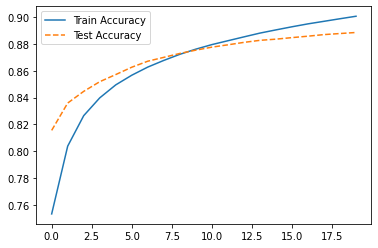

Train Accuracy:           0.9007342
Test Accuracy:            0.88861
Total Time Spent (min):   36.81787698666255


In [0]:
# Display a graph based on training and testing results from array along with runtime 

plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()

print("Train Accuracy:          ",np.array(train_accuracies[num_epoch-1]))
print("Test Accuracy:           ",np.array(test_accuracies[num_epoch-1]))
print("Total Time Spent (min):  ", spent_time/60)

https://cv-tricks.com/keras/understand-implement-resnets/








